# Train/Test the True Relationship Model

This notebook is design to predict DG relationships on the entity level. Here we are taking the input from this [paper](https://zenodo.org/record/1035500#.W3Hc-RgpBrk), prior probability notebook and the summary statistics notebook, then combinding it into a single dataset. From there we train a Ridge LR model and an elastic net LR model to make the final prediction.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import re
from scipy.stats import fisher_exact
from scipy.special import logit
import scipy
from sqlalchemy import and_
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Incorporate [Russ's Data](https://zenodo.org/record/1035500#.W3Hc-RgpBrk) into our Entity Dataframe

In [2]:
named_columns = ["pubmed_id", "sentence_num", "first_entity", 
                 "first_entity_location", "second_entity", "second_entity_location", 
                 "first_entity_string", "second_entity_string", "first_entity_db_id", 
                 "second_entity_db_id", "first_entity_type", "second_entity_type", 
                 "dependency_path", "sentence_string"
                ]
russ_df = pd.read_table("data/disease_gene/disease_associates_gene/biclustering/part-ii-dependency-paths-gene-disease-sorted-with-themes.txt", 
                        names=named_columns)
russ_df.head(2)

,pubmed_id,sentence_num,first_entity,first_entity_location,second_entity,second_entity_location,first_entity_string,second_entity_string,first_entity_db_id,second_entity_db_id,first_entity_type,second_entity_type,dependency_path,sentence_string
0,27955536,7,101F6,"1227,1232",lung_cancers,"1204,1216",101F6,lung cancers,11068,MESH:D008175,Gene,Disease,expressed|dobj|START_ENTITY expressed|nsubj|EN...,All normal lung bronchial epithelial cells and...
1,11980673,2,101F6,"483,488",tumor,"529,534",101F6,tumor,11068,MESH:D009369,Gene,Disease,effects|dep|START_ENTITY studied|dobj|effects ...,We studied the effects of six of these 3p21 .3...


In [3]:
disease_gene_df = pd.read_csv("data/disease_gene_summary_stats.csv")
disease_gene_df.head(2)

,disease_id,disease_name,gene_id,gene_name,nlog10_p_value,co_odds_ratio,co_expected_sen_count,delta_lower_ci,lstm_avg_marginal,lstm_marginal_0_quantile,lstm_marginal_20_quantile,lstm_marginal_40_quantile,lstm_marginal_60_quantile,lstm_marginal_80_quantile,hetnet_labels
0,DOID:12849,autistic disorder,3569,IL6,2.072881e-04,0.617773,62.795531,-0.001252,0.747175,0.075081,0.650967,0.907099,0.913931,0.916503,1
1,DOID:3070,malignant glioma,567,B2M,3.358850e-09,0.192395,86.200979,-0.025416,0.130409,0.076953,0.078801,0.081089,0.082576,0.086210,-1


In [4]:
disease_gene_russ_df = (
    disease_gene_df[[col for col in disease_gene_df.columns if "lstm" not in col]]
    .astype({'disease_name':str, 'gene_name':str})
    .merge(
        russ_df
        .astype({'first_entity':str, 'second_entity':str}),
        left_on=["gene_name", "disease_name"], right_on=["first_entity", "second_entity"], how='left')
)
(
    disease_gene_russ_df[
        ["disease_id", "disease_name", "gene_id", 
         "gene_name", "nlog10_p_value", "co_odds_ratio", 
         "co_expected_sen_count", "delta_lower_ci", "hetnet_labels", 
         "pubmed_id", "sentence_num", "dependency_path", "sentence_string"]
    ]
    .head(2)
)

,disease_id,disease_name,gene_id,gene_name,nlog10_p_value,co_odds_ratio,co_expected_sen_count,delta_lower_ci,hetnet_labels,pubmed_id,sentence_num,dependency_path,sentence_string
0,DOID:12849,autistic disorder,3569,IL6,2.072881e-04,0.617773,62.795531,-0.001252,1,NaN,NaN,NaN,NaN
1,DOID:3070,malignant glioma,567,B2M,3.358850e-09,0.192395,86.200979,-0.025416,-1,NaN,NaN,NaN,NaN


In [5]:
# fix the dependency path strings so they will match
def fix(x):
    x = re.sub('START_ENTITY', 'start_entity', x)
    x = re.sub('END_ENTITY', 'end_entity', x)
    return x

In [6]:
disease_gene_russ_df.dependency_path = disease_gene_russ_df.dependency_path.astype(str).apply(fix)

In [7]:
theme_dist_df = pd.read_table("data/disease_gene/disease_associates_gene/biclustering/part-i-gene-disease-path-theme-distributions.txt")
theme_dist_df.head(2)

,path,U,U.ind,Ud,Ud.ind,D,D.ind,J,J.ind,Te,...,Y,Y.ind,G,G.ind,Md,Md.ind,X,X.ind,L,L.ind
0,correlated|nsubj|start_entity correlated|nmod|...,0.0,0,1.0,0,0.0,0,28.0,0,5.0,...,4.0,0,2.0,0,5.0,0,11.0,0,1.0,0
1,vector|compound|start_entity transfected|nmod|...,1.0,0,0.0,0,2.0,0,1.0,0,0.0,...,1.0,0,0.0,0,1.0,0,1.0,0,14.0,0


In [ ]:
# fix the dependency path strings so they will match
def fix(x):
    x = re.sub('START_ENTITY', 'start_entity', x)
    x = re.sub('END_ENTITY', 'end_entity', x)
    return x

In [ ]:
disease_gene_russ_df.dependency_path = disease_gene_russ_df.dependency_path.astype(str).apply(fix)

In [8]:
final_dg_df = (
    disease_gene_russ_df
    .astype({'dependency_path':str})
    .merge(theme_dist_df.astype({"path":str}), left_on='dependency_path', right_on='path', how='left')
)
final_dg_df.head(2)

,disease_id,disease_name,gene_id,gene_name,nlog10_p_value,co_odds_ratio,co_expected_sen_count,delta_lower_ci,hetnet_labels,pubmed_id,...,Y,Y.ind,G,G.ind,Md,Md.ind,X,X.ind,L,L.ind
0,DOID:12849,autistic disorder,3569,IL6,2.072881e-04,0.617773,62.795531,-0.001252,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DOID:3070,malignant glioma,567,B2M,3.358850e-09,0.192395,86.200979,-0.025416,-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Transform the nans into 0.0 and aggregate the other sentnece scores
final_dg_df[['U', 'U.ind','Ud', 'Ud.ind',
     'D', 'D.ind', 'J', 'J.ind',
     'Y', 'Y.ind', 'G', 'G.ind', 
     'Md', 'Md.ind', 'X', 'X.ind', 
     'L', 'L.ind']] = (
    final_dg_df.groupby(["disease_id", "gene_id"])[
        ['U', 'U.ind','Ud', 'Ud.ind',
         'D', 'D.ind', 'J', 'J.ind', 
         'Y', 'Y.ind', 'G', 'G.ind', 
         'Md', 'Md.ind', 'X', 'X.ind', 
         'L', 'L.ind']]
    .transform('sum')
)
final_dg_df.head(2)

,disease_id,disease_name,gene_id,gene_name,nlog10_p_value,co_odds_ratio,co_expected_sen_count,delta_lower_ci,hetnet_labels,pubmed_id,...,Y,Y.ind,G,G.ind,Md,Md.ind,X,X.ind,L,L.ind
0,DOID:12849,autistic disorder,3569,IL6,2.072881e-04,0.617773,62.795531,-0.001252,1,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DOID:3070,malignant glioma,567,B2M,3.358850e-09,0.192395,86.200979,-0.025416,-1,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
(
    final_dg_df
    .drop_duplicates(["disease_name", "gene_name"])
    .to_csv("data/disease_gene/disease_associates_gene/disease_gene_summary_stats_dep_path.tsv", sep="\t", index=False)
)

# Load the Newly Transformed Data

In [11]:
candidate_df = (
    pd.read_table("data/disease_gene/disease_associates_gene/disease_gene_summary_stats_dep_path.tsv")
    .drop(['first_entity', 'first_entity_location',
       'second_entity', 'second_entity_location', 'first_entity_string',
       'second_entity_string', 'first_entity_db_id', 'second_entity_db_id',
       'first_entity_type', 'second_entity_type', 'dependency_path',
       'sentence_string', 'sentence_num', 'path', 'pubmed_id', 'Te', 'Te.ind'], axis=1)
)
candidate_df.head(2)

,disease_id,disease_name,gene_id,gene_name,nlog10_p_value,co_odds_ratio,co_expected_sen_count,delta_lower_ci,hetnet_labels,U,...,Y,Y.ind,G,G.ind,Md,Md.ind,X,X.ind,L,L.ind
0,DOID:12849,autistic disorder,3569,IL6,2.072881e-04,0.617773,62.795531,-0.001252,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DOID:3070,malignant glioma,567,B2M,3.358850e-09,0.192395,86.200979,-0.025416,-1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
prior_df = pd.read_csv("data/observation-prior.csv")
prior_df["logit_prior_perm"] = logit(prior_df["prior_perm"])
prior_df.head(2)

,disease_id,gene_id,disease_associates,gene_associates,prior_perm,prior_perm_stderr,logit_prior_perm
0,DOID:2531,7124,550,47,0.870898,0.000558,1.908922
1,DOID:2531,7157,550,46,0.867094,0.000565,1.875505


# Set up the Training and Testing Set

In [13]:
total_df = (
    pd.read_csv("data/disease-gene-pairs-association.csv.xz", compression='xz')
    .rename(index=str,columns={'entrez_gene_id': 'gene_id', 'doid_id': 'disease_id'})
)
total_df.head()

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene_id,gene_symbol,disease_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.85860,1
1,1,A1BG,DOID:1319,brain cancer,NaN,0,0,0,0.36785,0
2,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0
3,1,A1BG,DOID:263,kidney cancer,NaN,0,0,0,0.87328,1
4,1,A1BG,DOID:1793,pancreatic cancer,NaN,0,10,1,0.17837,0


In [14]:
# Gather the summary stats for each candidate
training_set = pd.merge(candidate_df, total_df.query("has_sentence==1&split==0")[["disease_id", "gene_id", "hetionet"]], 
                        how='inner',on=["disease_id", "gene_id"])
dev_set = pd.merge(candidate_df, total_df.query("has_sentence==1&split==1")[["disease_id", "gene_id", "hetionet"]],
                   how='inner', on=["disease_id", "gene_id"])
test_set = pd.merge(candidate_df, total_df.query("has_sentence==1&split==2")[["disease_id", "gene_id", "hetionet"]], 
                    how='inner', on=["disease_id", "gene_id"])


# Drop the values that aren't found in pubmed. 
training_set = training_set.drop("hetnet_labels", axis=1)
dev_set = dev_set.drop("hetnet_labels", axis=1)
test_set = test_set.drop("hetnet_labels", axis=1)

# Add the prior prob to the different sets 
training_set = pd.merge(training_set, prior_df[["disease_id", "gene_id", "logit_prior_perm"]], 
                        on=['disease_id', 'gene_id'])
dev_set = pd.merge(dev_set, prior_df[["disease_id", "gene_id", "logit_prior_perm"]], 
                  on=['disease_id', 'gene_id'])
test_set = pd.merge(test_set, prior_df[["disease_id", "gene_id", "logit_prior_perm"]], 
                   on=['disease_id', 'gene_id'])

In [15]:
non_features = [
    "hetionet", "disease_id", "gene_id", 
    "gene_name", "disease_name",
    "pubmed_id"
]

X = training_set[[col for col in training_set.columns if col not in non_features]]
Y = training_set["hetionet"]

X_dev = dev_set[[col for col in dev_set.columns if col not in non_features]]
Y_dev = dev_set["hetionet"]

X_test = test_set[[col for col in test_set.columns if col not in non_features]]
Y_test = test_set["hetionet"]

In [16]:
print(Y.value_counts())
print()
print(Y_dev.value_counts())
print()
print(Y_test.value_counts())
print()

0    62036
1     6636
Name: hetionet, dtype: int64

0    17720
1     1895
Name: hetionet, dtype: int64

0    8805
1     947
Name: hetionet, dtype: int64



In [17]:
train_Y = Y.append(Y_dev)
train_X = X.append(X_dev)

# Train the Machine Learning Algorithms

Here we use gridsearch to optimize both models using 10 fold cross validation. After exhausting the list of parameters, the best model is chosen and analyzed in the next chunk. 

In [18]:
n_iter = 100
final_models = []

lr = LogisticRegression()
lr_grid = {'C':np.linspace(1, 100, num=100)}

lr_normalizer_no_russ = StandardScaler()
lr_normalizer = StandardScaler()

In [19]:
%%time

russ_data = ['U', 'U.ind', 'Ud', 'Ud.ind', 'D', 'D.ind', 'J',
       'J.ind', 'Y', 'Y.ind', 'G', 'G.ind', 'Md', 'Md.ind', 'X', 'X.ind', 'L',
       'L.ind']

transformed_X_no_russ = lr_normalizer_no_russ.fit_transform(train_X[[col for col in train_X.columns if col not in russ_data]])
transformed_X = lr_normalizer.fit_transform(train_X)

CPU times: user 39.2 ms, sys: 257 µs, total: 39.4 ms
Wall time: 38.2 ms


In [20]:
%%time

final_model = GridSearchCV(lr, lr_grid, cv=10, n_jobs=3, scoring='roc_auc', return_train_score=True)
final_model.fit(transformed_X_no_russ, train_Y)
final_models.append(final_model)

CPU times: user 8.37 s, sys: 548 ms, total: 8.92 s
Wall time: 1min 17s


In [21]:
%%time

final_model = GridSearchCV(lr, lr_grid, cv=10, n_jobs=3, scoring='roc_auc', return_train_score=True)
final_model.fit(transformed_X, train_Y)
final_models.append(final_model)

CPU times: user 27.6 s, sys: 715 ms, total: 28.3 s
Wall time: 5min 18s


## Parameter Optimization

In [22]:
no_russ_result = pd.DataFrame(final_models[0].cv_results_)
russ_result = pd.DataFrame(final_models[1].cv_results_)

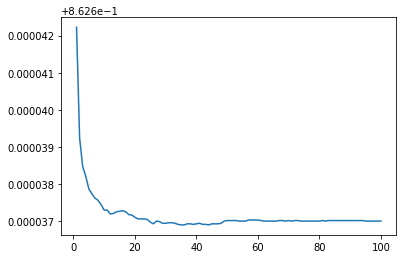

In [23]:
# No LSTM
plt.plot(no_russ_result['param_C'], no_russ_result['mean_test_score'])

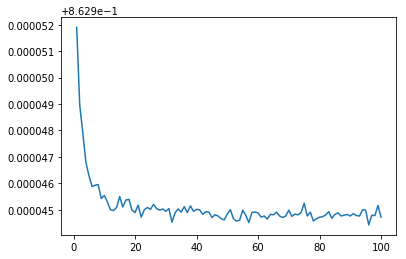

In [24]:
# LSTM
plt.plot(russ_result['param_C'], russ_result['mean_test_score'])

## LR Weights

In [25]:
list(zip(final_models[0].best_estimator_.coef_[0], [col for col in training_set.columns if col not in russ_data+non_features]))

[(0.76553903025724634, 'nlog10_p_value'),
 (0.50035515720196344, 'co_odds_ratio'),
 (0.011815480702881256, 'co_expected_sen_count'),
 (0.26490985116586235, 'delta_lower_ci'),
 (1.0818632053627644, 'logit_prior_perm')]

In [26]:
list(zip(final_models[1].best_estimator_.coef_[0], [col for col in training_set.columns if col not in non_features]))

[(0.75801845478496588, 'nlog10_p_value'),
 (0.50000926555619951, 'co_odds_ratio'),
 (0.012678257397734134, 'co_expected_sen_count'),
 (0.26175381499281347, 'delta_lower_ci'),
 (0.34703553251067049, 'U'),
 (0.0034978363707577256, 'U.ind'),
 (-0.20959290730492222, 'Ud'),
 (0.066091879873110645, 'Ud.ind'),
 (0.29557440010908975, 'D'),
 (-0.11773091544947101, 'D.ind'),
 (-0.039979293548300855, 'J'),
 (0.046350403477052028, 'J.ind'),
 (-0.041657637726158415, 'Y'),
 (0.1085960312406315, 'Y.ind'),
 (-0.085221969038367151, 'G'),
 (0.0352168086955768, 'G.ind'),
 (-0.080414576562468879, 'Md'),
 (0.0014326365262558385, 'Md.ind'),
 (0.22357299784807444, 'X'),
 (-0.046413882411044105, 'X.ind'),
 (-0.21339782268705174, 'L'),
 (0.042799587481914647, 'L.ind'),
 (1.072755614697511, 'logit_prior_perm')]

# Bar Plot AUROCS

(0.4, 1)

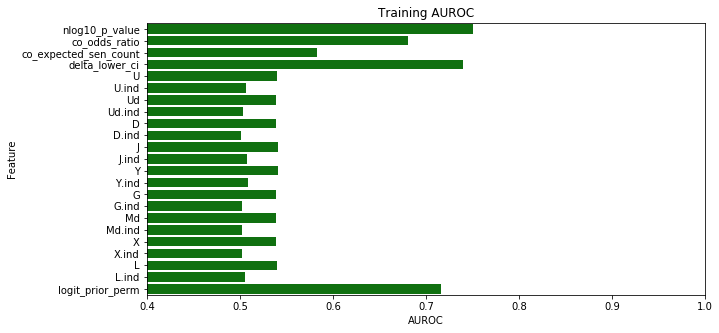

In [27]:
plt.figure(figsize=(10,5))
feature_rocs = []
for feature in X.columns:
    fpr, tpr, _ = roc_curve(train_Y, train_X[feature])
    feature_auc = auc(fpr, tpr)
    feature_rocs.append((feature, feature_auc))

feature_roc_df = pd.DataFrame(feature_rocs, columns=["Feature", "AUROC"])
ax = sns.barplot(x="AUROC", y="Feature", data=feature_roc_df, color='green')#palette=sns.color("Blue"))
plt.title("Training AUROC")
plt.xlim([0.4,1])

(0.4, 1)

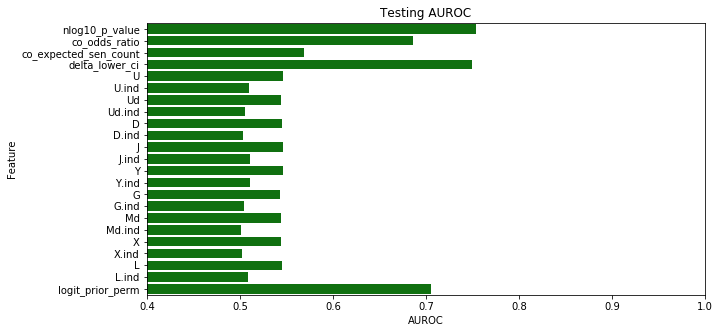

In [28]:
plt.figure(figsize=(10,5))
feature_rocs = []
for feature in X.columns:
    fpr, tpr, _ = roc_curve(Y_test, X_test[feature])
    feature_auc = auc(fpr, tpr)
    feature_rocs.append((feature, feature_auc))

feature_roc_df = pd.DataFrame(feature_rocs, columns=["Feature", "AUROC"])
ax = sns.barplot(x="AUROC", y="Feature", data=feature_roc_df, color='green')
plt.title("Testing AUROC")
plt.xlim([0.4,1])

# ROC CURVES

In [ ]:
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for feature in train_X:
    # Plot the p_values log transformed
    fpr, tpr, thresholds= roc_curve(train_Y, train_X[feature])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="{} (area = {:0.2f})".format(feature, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

In [ ]:
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

for feature in X:
    # Plot the p_values log transformed
    fpr, tpr, thresholds= roc_curve(Y_test, X_test[feature])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="{} (area = {:0.2f})".format(feature, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")

# Corerlation Matrix

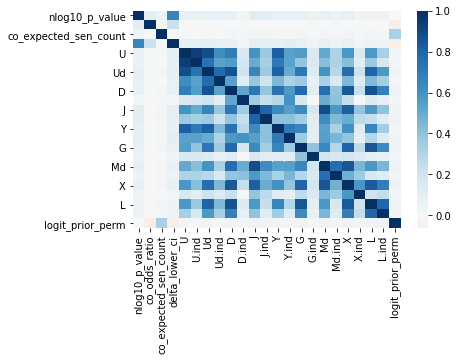

In [29]:
feature_corr_mat = train_X.corr()
sns.heatmap(feature_corr_mat, cmap="RdBu", center=0)

# ML Performance

In [30]:
transformed_tempX_test = lr_normalizer_no_russ.transform(X_test[[col for col in X.columns if col not in russ_data+non_features]])
transformed_X_test = lr_normalizer.transform(X_test)

In [31]:
colors = ["green","red"]
labels = ["LR_NO_RUSS","LR_RUSS"]

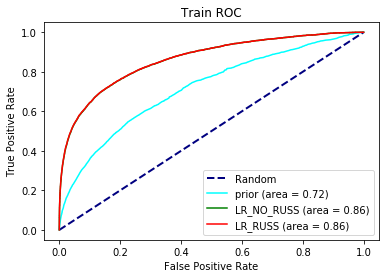

In [32]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

# Plot the p_values log transformed
fpr, tpr, thresholds= roc_curve(train_Y, train_X["logit_prior_perm"])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='cyan', label="{} (area = {:0.2f})".format("prior", model_auc))

fpr, tpr, thresholds= roc_curve(train_Y, final_models[0].predict_proba(transformed_X_no_russ)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[0], label="{} (area = {:0.2f})".format(labels[0], model_auc))

fpr, tpr, thresholds= roc_curve(train_Y, final_models[1].predict_proba(transformed_X)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[1], label="{} (area = {:0.2f})".format(labels[1], model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")

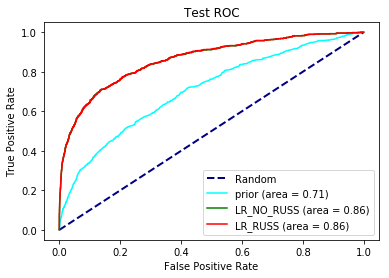

In [33]:
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random")

# Plot the p_values log transformed
fpr, tpr, thresholds= roc_curve(Y_test, X_test["logit_prior_perm"])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='cyan', label="{} (area = {:0.2f})".format("prior", model_auc))

fpr, tpr, thresholds= roc_curve(Y_test, final_models[0].predict_proba(transformed_tempX_test)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[0], label="{} (area = {:0.2f})".format(labels[0], model_auc))

fpr, tpr, thresholds= roc_curve(Y_test, final_models[1].predict_proba(transformed_X_test)[:,1])
model_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color=colors[1], label="{} (area = {:0.2f})".format(labels[1], model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")

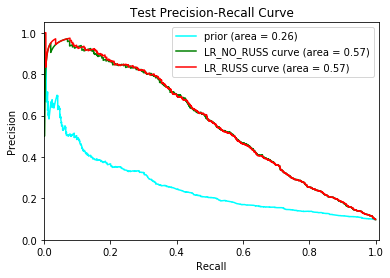

In [34]:
plt.figure()

# Plot the p_values log transformed
precision, recall, _= precision_recall_curve(Y_test, X_test["logit_prior_perm"])
model_precision = average_precision_score(Y_test, X_test["logit_prior_perm"])
plt.plot(recall, precision, color='cyan', label="{} (area = {:0.2f})".format("prior", model_precision))

precision, recall, _ = precision_recall_curve(Y_test, final_models[0].predict_proba(transformed_tempX_test)[:,1])
model_precision = average_precision_score(Y_test, final_models[0].predict_proba(transformed_tempX_test)[:,1])
plt.plot(recall, precision, color=colors[0], label="{} curve (area = {:0.2f})".format(labels[0], model_precision))
  
precision, recall, _ = precision_recall_curve(Y_test, final_models[1].predict_proba(transformed_X_test)[:,1])
model_precision = average_precision_score(Y_test, final_models[1].predict_proba(transformed_X_test)[:,1])
plt.plot(recall, precision, color=colors[1], label="{} curve (area = {:0.2f})".format(labels[1], model_precision))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Test Precision-Recall Curve')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="upper right")

## Save Final Result in DF

In [ ]:
predictions = final_models[1].predict_proba(train_X.append(X_test))
predictions_df = training_set.append(dev_set).append(test_set)[[
    "disease_id","disease_name", 
    "gene_id", "gene_name", 'hetnet']]
predictions_df["predictions"] = predictions[:,1]

In [ ]:
predictions_df.to_csv("data/vanilla_lstm/final_model_predictions.csv", index=False)